In [1]:
from PIL import Image, ImageDraw
import numpy as np
image = Image.open('gaussian-noise.jpg')

In [2]:
image.size

(233, 204)

In [3]:
# 將 PIL.image.image轉成 np.array
def image_to_array(image):
    image = np.array(image)
    return image

In [4]:
# RGB to gray_1
'''
gray = 0.299*R + 0.587*G + 0.114*B
'''
def gray_image_1(image):
    # 先轉成 RGB array
    image_array = np.array(image)
    h,w = image.size
    for x in range(w):
        for y in range(h):
            gray_value = 0.299*image_array[x,y,0] + 0.587*image_array[x,y,1] + 0.114*image_array[x,y,2]
            image_array[x,y,0] = gray_value
            image_array[x,y,1] = gray_value
            image_array[x,y,2] = gray_value
    return image_array

In [5]:
# RGB to gray_2，簡易型 但很爛 別用
'''
gray = (r+g+b)/2
'''
def gray_image_2(image):
    # 先轉成 RGB array
    image_array = np.array(image)
    h,w = image.size
    for x in range(w):
        for y in range(h):
            gray_value = (image_array[x,y,0] + image_array[x,y,1] + image_array[x,y,2])/2
            image_array[x,y,0] = gray_value
            image_array[x,y,1] = gray_value
            image_array[x,y,2] = gray_value
    return image_array

In [6]:
# RGB to XYZ色彩空間
'''
XYZ方便與 RGB色彩空間互相轉換
image 為 PIL.Image.Image
Image.fromarray(matrix, 'RGB')
'''
def rgb_to_xyz(image):
    rgb_array = np.array(image)
    h,w = image.size
    xyz_to_rgb_matrix = np.array[[[ 3.240479, -1.53715, -0.498535],
                                  [-0.969256, 1.875991,  0.041556],
                                  [ 0.055648,-0.204043,  1.057311]]]
    for x in range(w):
        for y in range(h):
            rgb_array 

In [7]:
'''
功能 : 先將圖片轉成大mesh
內容 : 這裡用的方法是以整塊的mesh為單位來移動，最後呈現的圖像會一格格的感覺。
'''
def to_mesh(image, n=11):
    #轉換array
    image_array = np.array(image)  
    
    image_array_mesh = []
    
    w,h = image.size
    count_x = 0
    count_y = 0
    
    h1,w1 = 0, 0
    #先根據 n去劃分mesh
    for y in np.arange(0, h, n):
        count_x = 0
        count_y += n
        for x in np.arange(0, w, n):
            h1 = int((x+n)/n-1)
            w1 = int((y+n)/n-1)
            if (w-count_x) > n and (h-count_y+n) > n:
                image_array_mesh.append(image_array[y:y+n, x:x+n])
            elif n > (w-count_x) > 0 and (h-count_y+n) > n:
                image_array_mesh.append(image_array[y:y+n, w-n:w])
            elif     (w-count_x) > n and n > (h-count_y+n) > 0:
                image_array_mesh.append(image_array[h-n:h, x:x+n])
            elif n > (w-count_x) > 0 and n > (h-count_y+n) > 0:
                image_array_mesh.append(image_array[h-n:h, w-n:w])
            else:
                print('X')
                pass
            count_x += n
    image_array_mesh = np.array(image_array_mesh)
    image_array_mesh = image_array_mesh.reshape(w1+1, h1+1, n ,n ,3)
    return  image_array_mesh

In [8]:
def mesh_to_array(image_array_mesh, image, n=11):
    '''
    image_array_mesh 的 shape為 (y_scale, x_scale, n, n,3)
    image為輸入的圖片，提供圖像大小來給定 空陣列的shape
    n為奇數，為mesh的大小
    '''
    a,b,c = np.array(image).shape
    z = np.zeros((a,b,c), dtype='uint8')
    h, w, r = z.shape
    count_x1 = 0
    count_y1 = 0
    for y in np.arange(0, h, n):
        count_x1 = 0
        count_y1 += n

        for x in np.arange(0, w, n):
            h1 = int((x+n)/n-1)
            w1 = int((y+n)/n-1)
            if   (w-count_x1) > n and (h-count_y1+n) >n:
                z[y:y+n, x:x+n] = image_array_mesh[w1, h1]
            elif  n > (w-count_x1) > 0 and (h-count_y1+n) >n:
                z[y:y+n, (w-n):w] = image_array_mesh[w1, h1]
            elif (w-count_x1) > n and n > (h-count_y1+n) > 0:
                z[(h-n):h, x:x+n] = image_array_mesh[w1, h1]
            elif n > (w-count_x1) >0 and n > (h-count_y1+n) > 0:
                z[(h-n):h, (w-n):w] = image_array_mesh[w1, h1]
            else:
                print('X')
                pass
            count_x1 += n
    return z

# 高斯濾波

In [10]:
# Gaussian filter
'''
image 為 PIL.Image.Image
n為陣列值3:3*3  5:5*5 7*7
n為奇數，為mesh的大小
'''
def gaussian_filter(image_array_mesh, image, Variance_mode ='gaussian',n=3):
    import math
    image_array_mesh = image_array_mesh
    w,h = image.size
    
    # 將大mesh取出做處理
    a,b,c,d,e = image_array_mesh.shape
    x_scale = 0
    y_scale = 0
    if c > w%c > 0:
        x_scale = (w//c)+1
    else:
        x_scale = w//c
    if c > h%c > 0:
        y_scale = (h//c)+1
    else:
        y_scale = h//c 
    print("x_scale:",x_scale)
    print("y_scale:",y_scale)
    '''
    如果(1920, 1080), n=500 ==> x_scale=4, y_scale=3
    '''
    
    # Gaussian
    gauss_value = np.zeros(3)
    Variance_1 = np.zeros(3)
    Variance = np.zeros(3)
    average = np.zeros(3)
    num = n**2
    
    count_y = 0
    
    for x in range(x_scale):
        for y in range(y_scale):
            # Gaussian mesh
            mesh_temp = image_array_mesh[y, x]
            mesh = np.zeros((n,n,(3)), dtype='uint8')
            x_mesh, y_mesh, z = mesh_temp.shape #5 5 3
        
            count_x = 0
            count_y = 0
            
            
            for y2 in np.arange(0, y_mesh, 1):
                for x2 in np.arange(0, x_mesh, 1):
                    if   (x2+n) < x_mesh and (y2+n) < y_mesh:
                        mesh = mesh_temp[x2:x2+n, y2:y2+n]
                        #print(1)
                    elif (x2+n) == x_mesh and (y2+n) < y_mesh:
                        mesh = mesh_temp[x_mesh-n:x_mesh, y2:y2+n]
                        #print(2)
                    elif (x2+n) < x_mesh and (y2+n) == y_mesh:
                        mesh = mesh_temp[x2:x2+n, y_mesh-n:y_mesh]
                        #print(3)
                    elif (x2+n) == x_mesh and (y2+n) == y_mesh:
                        mesh = mesh_temp[x_mesh-n:x_mesh, y_mesh-n:y_mesh]
                        #print(4)
                    else:
                        break
                        print("X")
            # Variance
            if Variance_mode == 'gaussian': 
                Variance_1 = np.zeros(3)
                Variance = np.zeros(3)
                for y2 in np.arange(0, n, 1):
                    for x2 in np.arange(0, n, 1):
                        for rgb in range(3):
                            average[rgb] = np.mean(mesh[:,:,(rgb)])
                            Variance_1[rgb] = (mesh[x2,y2,(rgb)]-average[rgb])**2
                            Variance[rgb] += Variance_1[rgb]
                for rgb in range(3):
                    Variance[rgb] = Variance[rgb] / num
                    if Variance[rgb] ==0 or Variance[rgb] < 0.001:
                        Variance[rgb] = 0.01
            else:
                Variance = np.array([Variance_mode, Variance_mode, Variance_mode])
                    
            for y2 in np.arange(0, y_mesh, 1):
                for x2 in np.arange(0, x_mesh, 1):
                    if   (x2+n) < x_mesh and (y2+n) < y_mesh:
                        mesh = mesh_temp[x2:x2+n, y2:y2+n]
                        #print(1)
                    elif (x2+n) == x_mesh and (y2+n) < y_mesh:
                        mesh = mesh_temp[x_mesh-n:x_mesh, y2:y2+n]
                        #print(2)
                    elif (x2+n) < x_mesh and (y2+n) == y_mesh:
                        mesh = mesh_temp[x2:x2+n, y_mesh-n:y_mesh]
                        #print(3)
                    elif (x2+n) == x_mesh and (y2+n) == y_mesh:
                        mesh = mesh_temp[x_mesh-n:x_mesh, y_mesh-n:y_mesh]
                        #print(4)
                    else:
                        break
                        print("X")
                    
                    gaussian_mesh = np.zeros((n,n,(3)), dtype='float')
                    count = 0
                    for cy in range(n):
                        for cx in range(n):
                            for y1 in np.arange(-cy, n-cy, 1):
                                for x1 in np.arange(-cx, n-cx, 1):
                                    for rgb in range(3):
                                        #print(Variance[rgb])
                                        #print(x1)
                                        #print(y1)
                                        gaussian_mesh[x1, y1, (rgb)] = (1/(2*(math.pi)*Variance[rgb]))*(math.exp(-(x1**2+y1**2)/(2*Variance[rgb])))
                                        #print(gaussian_mesh[x1, y1, (rgb)])
                            #print(gaussian_mesh)
                            for rgb in range(3):
                                sum_gaussian = np.sum(gaussian_mesh[:,:,(rgb)])
                                if sum_gaussian < 0.000001:
                                    sum_gaussian = 0.01
                                gaussian_mesh[:,:,(rgb)] = gaussian_mesh[:,:,(rgb)] / sum_gaussian
                                #print(gaussian_mesh[:,:,(rgb)])
                                mesh[cx, cy,(rgb)] = np.sum(mesh[:,:,(rgb)]*gaussian_mesh[:,:, (rgb)])
                                #print(a[rgb])
    return image_array_mesh

x_scale: 22
y_scale: 19


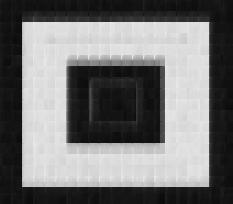

In [31]:
image_input = to_mesh(image, 11)
image_input_gaussian = gaussian_filter(image_input, image, 5)
output = mesh_to_array(image_input_gaussian, image, 11)
Image.fromarray(output, 'RGB')

x_scale: 22
y_scale: 19


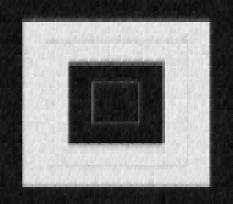

In [30]:
image_input = to_mesh(image, 11)
image_input_gaussian = gaussian_filter(image_input, image, 3)
output = mesh_to_array(image_input_gaussian, image, 11)
Image.fromarray(output, 'RGB')

x_scale: 22
y_scale: 19


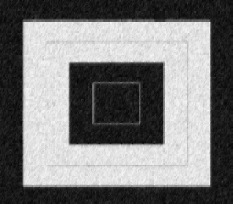

In [10]:
image_input = to_mesh(image, 11)
image_input_gaussian = gaussian_filter(image_input, image, 2)
output = mesh_to_array(image_input_gaussian, image, 11)
Image.fromarray(output, 'RGB')

x_scale: 22
y_scale: 19


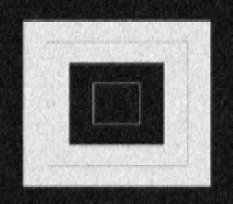

In [11]:
image_input = to_mesh(image, 11)
image_input_gaussian = gaussian_filter(image_input, image, 2, 2)
output = mesh_to_array(image_input_gaussian, image, 11)
Image.fromarray(output, 'RGB')

x_scale: 22
y_scale: 19


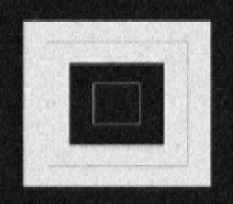

In [16]:
image_input = to_mesh(image, 11)
image_input_gaussian = gaussian_filter(image_input, image, 1.2, 2)
output = mesh_to_array(image_input_gaussian, image, 11)
Image.fromarray(output, 'RGB')

# 銳化處理

In [19]:
#def Sharpening_filter(image_array):

#n為kernel
#這裡會使用邊緣擴增的方式來完成捲積

image_array = image_to_array(image)
n = 3
# 銳化的mesh
window = ([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])
# 邊緣擴增，因為捲積會變小
h, w, nouse = image_array.shape
zero_array = np.zeros(n)
image_array = np.insert(image_array, 0, zero_array, axis=0) #上
image_array = np.insert(image_array, h, zero_array, axis=0) #下
image_array = np.insert(image_array, 0, zero_array, axis=1) #左
image_array = np.insert(image_array, w, zero_array, axis=1) #右

temp_image_array = np.zeros([h,w,(3)])

# 對整個圖做 卷積，逐一取出小 mesh (slider window)
mesh = np.zeros((n,n,(3)), dtype='uint8')
x_mesh, y_mesh, z = image_array.shape
count_x = 0
count_y = 0
for y in np.arange(0, y_mesh, 1):
    print(0)
    for x in np.arange(0, x_mesh, 1):
        if   (x+n) < x_mesh and (y+n) < y_mesh:
            mesh = image_array[x:x+n, y:y+n]
            #print(1)
        elif (x+n) == x_mesh and (y+n) < y_mesh:
            mesh = image_array[x_mesh-n:x_mesh, y:y+n]
            #print(2)
        elif (x+n) < x_mesh and (y+n) == y_mesh:
            mesh = image_array[x:x+n, y_mesh-n:y_mesh]
            #print(3)
        elif (x+n) == x_mesh and (y+n) == y_mesh:
            mesh = image_array[x_mesh-n:x_mesh, y_mesh-n:y_mesh]
            #print(4)
        else:
            break
            print("X")
        # 要取代的pixel
        print(1)
        for y2 in np.arange(1, y_mesh-1, 1):
            for x2 in np.arange(1, x_mesh-1, 1):
                for rgb in range(3):
                    temp_image_array[x2, y2,(rgb)] = np.sum(mesh[rgb]*window)
#return temp_image_array

0
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

In [9]:
from PIL import Image, ImageDraw
import numpy as np
image = Image.open('gaussian-noise.jpg')

In [10]:
n=3
image_array = image_to_array(image)
h, w, nouse = image_array.shape

zero_array = np.zeros(n)
image_array = np.insert(image_array, 0, zero_array, axis=0) #上
image_array = np.insert(image_array, h, zero_array, axis=0) #下
image_array = np.insert(image_array, 0, zero_array, axis=1) #左
image_array = np.insert(image_array, w, zero_array, axis=1) #右

image = Image.fromarray(image_array, 'RGB')

image_array_mesh = to_mesh(image, 11)
#w,h = image.size

# 銳化的mesh
window = ([
    [ 0, -1, 0],
    [-1,  4, -1],
    [ 0, -1, 0]
])

a,b,c,d,e = image_array_mesh.shape
temp_image_array_mesh = np.zeros([a,b,c,d,(3)])

# 將大mesh取出做處理
x_scale = 0
y_scale = 0
if c > w%c > 0:
    x_scale = (w//c)+1
else:
    x_scale = w//c
if c > h%c > 0:
    y_scale = (h//c)+1
else:
    y_scale = h//c 
print("x_scale:",x_scale)
print("y_scale:",y_scale)
'''
如果(1920, 1080), n=500 ==> x_scale=4, y_scale=3
'''
count_y = 0
for x in range(x_scale):
    for y in range(y_scale):
        # Gaussian mesh
        mesh_temp = image_array_mesh[y, x]
        mesh = np.zeros((n,n,(3)), dtype='uint8')
        x_mesh, y_mesh, z = mesh_temp.shape #5 5 3

        count_x = 0
        count_y = 0


        for y2 in np.arange(0, y_mesh, 1):
            for x2 in np.arange(0, x_mesh, 1):
                if   (x2+n) < x_mesh and (y2+n) < y_mesh:
                    mesh = mesh_temp[x2:x2+n, y2:y2+n]
                    #print(1)
                elif (x2+n) == x_mesh and (y2+n) < y_mesh:
                    mesh = mesh_temp[x_mesh-n:x_mesh, y2:y2+n]
                    #print(2)
                elif (x2+n) < x_mesh and (y2+n) == y_mesh:
                    mesh = mesh_temp[x2:x2+n, y_mesh-n:y_mesh]
                    #print(3)
                elif (x2+n) == x_mesh and (y2+n) == y_mesh:
                    mesh = mesh_temp[x_mesh-n:x_mesh, y_mesh-n:y_mesh]
                    #print(4)
                else:
                    break
                    print("X")
                # 要取代的pixel
                #print(1)
                for y4 in np.arange(0, y_mesh, 1):
                    for x4 in np.arange(0, x_mesh, 1):
                        for rgb in range(3):
                            #print(np.sum(mesh[rgb]*window))
                            pixel_value =  np.sum(mesh[rgb]*window) 
                            if pixel_value<0:
                                pixel_value = 0
                            elif pixel_value>255:
                                pixel_value = 255
                            else:
                                pass
                            mesh_temp[x4, y4,(rgb)] = pixel_value
                            

x_scale: 22
y_scale: 19


KeyboardInterrupt: 

In [9]:
image_array_mesh[0,0]

NameError: name 'image_array_mesh' is not defined

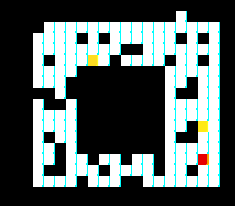

In [59]:
output = mesh_to_array(image_array_mesh, image, 11)
Image.fromarray(output, 'RGB')

In [23]:
a = image_to_array(image)
b = Sharpening_filter(a)

KeyboardInterrupt: 

# 中值濾波

In [ ]:
'''
輸入為mesh  ex:(19, 22, 11, 11, 3)
'''
def median_filter(image_array_mesh, image,):
    # 原圖的size (233, 204)
    w,h = image.size
    
    # 將大mesh取出做處理
    a,b,c,d,e = image_array_mesh.shape
    x_scale = 0
    y_scale = 0
    if c > w%c > 0:
        x_scale = (w//c)+1
    else:
        x_scale = w//c
    if c > h%c > 0:
        y_scale = (h//c)+1
    else:
        y_scale = h//c 
    print("x_scale:",x_scale)
    print("y_scale:",y_scale)
    
    # 逐一將大 mesh取出做處理
    for y in range(y_scale):
        for x in range(x_scale):
            temp = image_array_mesh[y, x]
            temp

In [21]:
a = to_mesh(image, 11)
a[0,0].shape

(11, 11, 3)

In [30]:
a[0,0,(0)]

array([[36, 36, 36],
       [44, 44, 44],
       [25, 25, 25],
       [58, 58, 58],
       [31, 31, 31],
       [ 0,  0,  0],
       [59, 59, 59],
       [19, 19, 19],
       [36, 36, 36],
       [32, 32, 32],
       [11, 11, 11]], dtype=uint8)

In [28]:
a[0,0][0].shape

(11, 3)

In [29]:
a[0,0]

array([[[36, 36, 36],
        [44, 44, 44],
        [25, 25, 25],
        [58, 58, 58],
        [31, 31, 31],
        [ 0,  0,  0],
        [59, 59, 59],
        [19, 19, 19],
        [36, 36, 36],
        [32, 32, 32],
        [11, 11, 11]],

       [[18, 18, 18],
        [ 9,  9,  9],
        [29, 29, 29],
        [ 4,  4,  4],
        [35, 35, 35],
        [16, 16, 16],
        [13, 13, 13],
        [13, 13, 13],
        [50, 50, 50],
        [30, 30, 30],
        [27, 27, 27]],

       [[17, 17, 17],
        [32, 32, 32],
        [38, 38, 38],
        [44, 44, 44],
        [21, 21, 21],
        [37, 37, 37],
        [26, 26, 26],
        [25, 25, 25],
        [33, 33, 33],
        [ 0,  0,  0],
        [ 9,  9,  9]],

       [[25, 25, 25],
        [48, 48, 48],
        [29, 29, 29],
        [24, 24, 24],
        [ 0,  0,  0],
        [36, 36, 36],
        [41, 41, 41],
        [15, 15, 15],
        [45, 45, 45],
        [32, 32, 32],
        [34, 34, 34]],

       [[38, 38, 38],
  

In [16]:
image.size

(233, 204)

In [18]:
image_array_mesh = to_mesh(image, 11)

In [20]:
    w,h = image.size
    a,b,c,d,e = image_array_mesh.shape
    x_scale = 0
    y_scale = 0
    if c > w%c > 0:
        x_scale = (w//c)+1
    else:
        x_scale = w//c
    if c > h%c > 0:
        y_scale = (h//c)+1
    else:
        y_scale = h//c 
    print("x_scale:",x_scale)
    print("y_scale:",y_scale)

x_scale: 22
y_scale: 19


In [7]:
a = to_mesh(image, 11)

In [8]:
a.shape

(19, 22, 11, 11, 3)

In [9]:
a[0,0].shape

(11, 11, 3)

In [10]:
a[0,0][0].shape

(11, 3)

In [12]:
a[0,0,(0)].shape

(11, 3)

In [13]:
a[0,0][0]

array([[36, 36, 36],
       [44, 44, 44],
       [25, 25, 25],
       [58, 58, 58],
       [31, 31, 31],
       [ 0,  0,  0],
       [59, 59, 59],
       [19, 19, 19],
       [36, 36, 36],
       [32, 32, 32],
       [11, 11, 11]], dtype=uint8)

In [14]:
a[0,0,(0)]

array([[36, 36, 36],
       [44, 44, 44],
       [25, 25, 25],
       [58, 58, 58],
       [31, 31, 31],
       [ 0,  0,  0],
       [59, 59, 59],
       [19, 19, 19],
       [36, 36, 36],
       [32, 32, 32],
       [11, 11, 11]], dtype=uint8)

In [11]:
image.size

(233, 204)

In [ ]:
%run other.ipynb

from PIL import Image, ImageDraw
import numpy as np
image = Image.open('test/dog1.jpg')
image_array = np.array(image)

import matplotlib.pyplot as plt
import numpy as np
import copy

image_array = other_class.RGB_to_HSV(image_array)

In [ ]:
def histogram_equalization_HSV_grobel_and_partial(image_array_input):
    import copy
    image_array = copy.copy(image_array_input)
    
    '''
    HSV
    輸入為r
    轉換為g
    輸出為s
    '''
    # 只取v來做HE。  v = 0~1，為了方便計算，都*255變成0~255。
    image_array_v = image_array[:,:,(2)]*255
    image_array_v = image_array_v.astype('uint8')
    # 對 v做hist
    hist_r,bins = np.histogram(image_array_v.flatten(), bins=256, range=[0,256])

    #對r做 pdf累積=cdf
    cdf_r = hist_r.cumsum()
    # cdf是數量的累積，正規化到最大值為其中中數量最大的值，這樣cdf曲線可以和hist放在同一張圖。
    cdf_r_normalized = cdf_r * hist_r.max() / cdf_r.max()

    plt.subplot(221)
    plt.plot(np.arange(0,256,1) ,cdf_r_normalized, color='b')
    plt.hist(image_array_v.flatten(), bins=256, range=[0,256], color = 'r')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc='upper left')
    
    # calculate cdf
    # np.ma.masked_equal(array, 0)會設置一個遮罩，可以將array中為0的不會被做任何運算
    cdf_m = np.ma.masked_equal(cdf_r, 0)
    cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max() - cdf_m.min())
    # np.ma.filled(array, 0) 將為True的遮罩放入0，等於是之前拿掉0 現在只是重新放回來。
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')

    # mapping映射 ，cdf四捨五入後為0~255的HE排列。 
    # cdf[array]會將array的值變成'索引值'帶入cdf，根據cdf索引值位置的值來做替換
    '''ex:
    a = np.array([0,1,2,3,4,4,6])
    b = np.array([5,5,5])
    a[b]
    >>>array([4, 4, 4])
    '''
    image_array_new = cdf[image_array_v]

    # HE完成後，跟之前一樣出一張cdf和pdf的圖
    # 區間0~256 放入array中元素對應的個數
    hist_s, bins_s = np.histogram(image_array_new.flatten(), bins= 256, range=[0, 256])
    cdf_s = hist_s.cumsum()
    cdf_s_normalized = cdf_s * hist_s.max() / cdf_s.max()

    plt.subplot(222)
    plt.plot(np.arange(0,256,1), cdf_s_normalized, color='b')
    plt.hist(image_array_new.flatten(), 256, [0, 256], color = 'r')
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc='upper left')

    plt.subplot(223)
    plt.imshow(other_class.HSV_to_RGB(image_array_input))
    
    plt.subplot(224)
    image_array[:,:,(2)] = image_array_new/255
    plt.imshow(other_class.HSV_to_RGB(image_array))
    plt.show()